In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import unittest
import csv
import gc
import sys
%run helper_fns.ipynb
%run probability_fns.ipynb
%run likelihood_fns.ipynb
%run sampling_fns.ipynb

...........
----------------------------------------------------------------------
Ran 11 tests in 0.010s

OK
...........
----------------------------------------------------------------------
Ran 11 tests in 0.009s

OK
......
----------------------------------------------------------------------
Ran 6 tests in 0.011s

OK
...........
----------------------------------------------------------------------
Ran 11 tests in 0.010s

OK
...........
----------------------------------------------------------------------
Ran 11 tests in 0.010s

OK
...

end is lower than start; can happen and will return 0 which will cause neg infs later: [-inf, 0.0, -1.0, 1.0, inf]
end is lower than start; can happen and will return 0 which will cause neg infs later: [-inf, 0.0, -1.0, 1.0, inf]


...
----------------------------------------------------------------------
Ran 6 tests in 0.013s

OK
../var/folders/z3/65sxpv5n3csdhfzm0ysx30940000gp/T/ipykernel_2316/1839039262.py:51: RuntimeWarning: divide by zero encountered in log
  LLQ += counts * np.log(prob) # this means fewer calls to lookup table
/var/folders/z3/65sxpv5n3csdhfzm0ysx30940000gp/T/ipykernel_2316/110277214.py:253: RuntimeWarning: divide by zero encountered in log
  real_LP_1 = np.sum(np.log([max(0,
.

some thetas out of order: [-inf, 1.5, 1.3, 3.5, inf]; test: [False  True False False  True]
np.inf returned; should only really happen with thetas out of order:[-inf, 1.5, 1.3, 3.5, inf]
LL: -inf
LP: -3.4768155996140178
A is -inf: A -inf; A1 -inf A2 -6.92554331291155 A3 -0.2255550003176261



----------------------------------------------------------------------
Ran 3 tests in 0.021s

OK


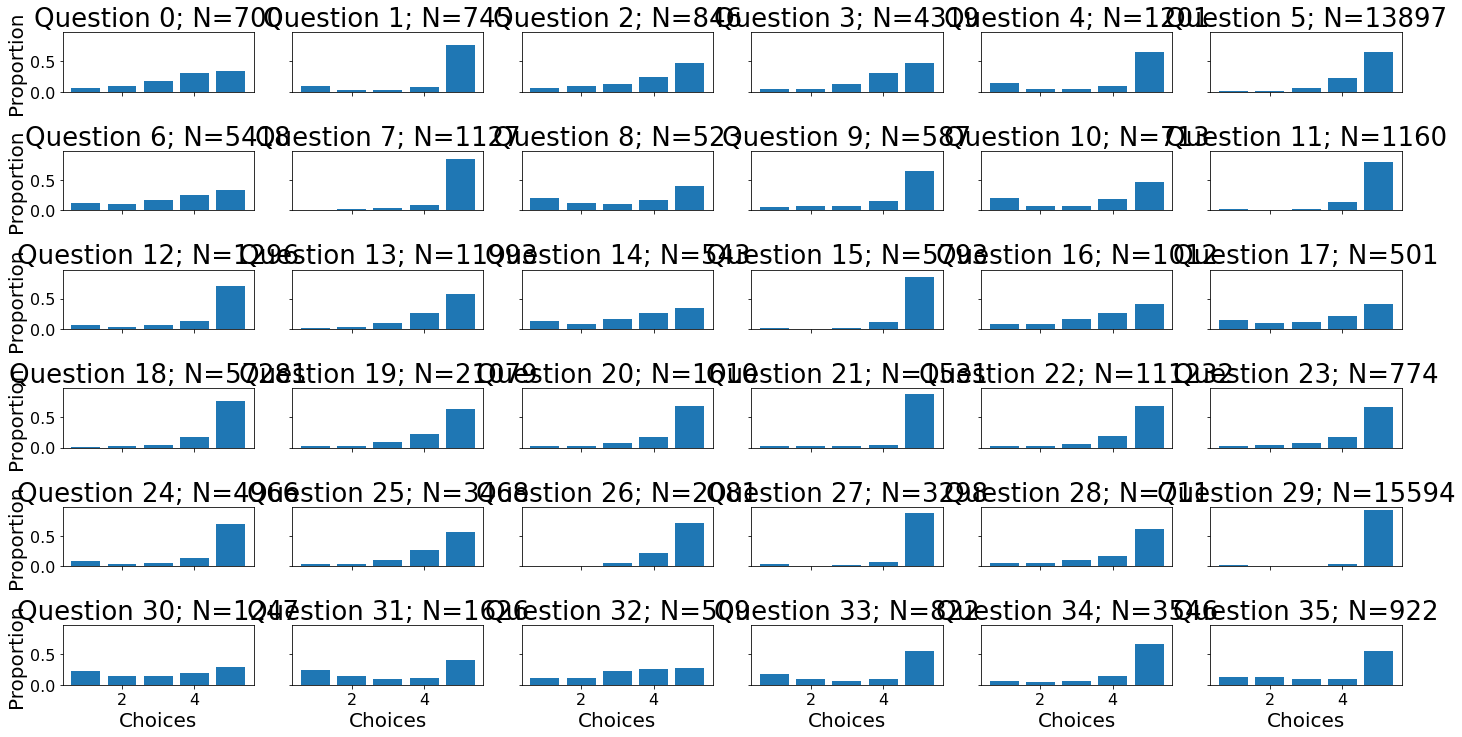

In [2]:
data_dir = 'data'
load_path = '{}/MoviesData.npy'.format(data_dir)
cleanData = load_cleaned_data(load_path)
plot_data(cleanData)

## Likelihood functions and checks
This notebook is to be used as a submodule that contains wrappers for all the likelihood functions used by the ordinal probit model for survey data, and Metropolis-Hastings sampler. There is also an optional testing suite.

In [3]:
class OrdinalProbitSurveyData():
    """A class to fit ordinal probit models to survey data using MCMC. Meant to implement the model in 
    "Analyzing ordinal data with metric models: What could possibly go wrong?""
    Torrin M.Liddell and John K.Kruschke (2018)
    https://www.sciencedirect.com/science/article/abs/pii/S0022103117307746
    
    Initial implementation: Ruairidh McLennan Battleday
    
    Inputs
    ---------
    
    surveyResponses: matrix of ints or list or list of ints. Each row or list contains the counts of responses
                     to a particular question, where the answers form an ordinal list (ordered sequence)
                     and each entry is the counts for each answer. That is, entry 0 (0-based indexing) contains
                     the counts for answer 1 (1-based indexing) to that question. 
                     All rows or questions must have the same meaning and permissible responses
                     (e.g., similarity, 1=highly similar, 9=not at all similar, etc).
                     
                     
    k: int; the number of applicable responses. This will be used to define a range of possible responses
                    from 0:k-1.
                    
                    
    num_samples: number of MCMC samples after discarding burn in samples;
    slice_frequency: how frequently to retain samples after burn in samples;
    print_frequency: how frequently to print.
    
    printing: whether to call subfunctions and methods with printing on (prints all intermediate values)
    debug: whether to run assertion statements within subfunctions.
    
    Structures
    --------------
    param_dict: a dictionary of variables and arguments for each parameter, which are used to conduct MCMC. 
                Should contain the parameter name as key, which returns a sub dictionary.
                Each subdictionary has the following key:value pairs
                "value" key that stores its value
                "proposal_function" key, which contains the proposal function
                "proposal" key, which stores a list of proposal function arguments
                "acceptance_function" key, which stores the acceptance function
                "acceptance" key, which stores the acceptance function arguments.
                
    Methods
    -------------
    Cycle function, which updates a single parameter, and then updates dependencies.
                    
    Outputs
    -----------
    Each of the below will be embedded into a matrix of K x S, where K is the size of the paramter vector in question,
    and S is the number of retained MCMC samples.
    
    mus: vector of floats. These are the mean parameters for the latent Gaussians underlying each question;
    sigmas: vector of floats from positive reals. These are the sd parameters for the latent Gaussians underlying each question;
    thetas: vector of floats from positive reals; ascending sequence. These define the quantiles used to calculate
            the mean response for a question / the response thresholds determining the probability of any given answer.
    """
    
    def __init__(self, surveyResponses, k, num_samples=1000, slice_frequency=100, print_frequency=100,
                printing=False, debug=False):
        
        self.surveyResponses = surveyResponses
        self.Q = None
        self.k = k
        self.num_samples = num_samples
        self.slice_frequency = slice_frequency
        self.print_frequency = print_frequency
        self.printing = printing
        self.debug = debug
        self.param_dict = {}
        self.paramList = None # initialized below
        
        self.mu_0 = (self.k+1)/2
        self.sigma_0 = self.k
        self.sigma_prop = 0.3 # proposal function SD
        self.gamma_mean = 3.0 # mean of gamma prior on sigmas; note, original paper used 3.0 as mode, 
        # but I've changed this to mean for ease of conversion (was it a typo in original paper?)
        self.gamma_spread = 3.0 # sd of gamma prior on sigmas
        self.theta_shift = 0.5
        self.lower = 1.5
        self.upper = k-0.5
        
        self.initialize()

        
    def initialize(self):
        try:
            self.surveyResponses = np.int_(np.array(self.surveyResponses))
        except Exception as E:
            print(E)
            print("Survey responses are the wrong format: should be List of Lists of ints" + \
            "with each subList the same length; or, matrix of ints.")
        assert self.surveyResponses.shape[-1] == self.k, "mismatch between number of columns in surveyResponses and k {} vs {}".format(self.surveyResponses[-1],
                                                                                                                                 k)
        # first establish global and prior parameters; taken from original paper
        self.Q = self.surveyResponses.shape[0]
        self.current_values = {'mu': np.empty(self.Q), 'sigma': np.empty(self.Q), 'theta': np.empty(self.k+1)}
        self.current_values['theta'][0] = -np.inf
        self.current_values['theta'][1] = self.lower
        self.current_values['theta'][self.k] = np.inf
        self.current_values['theta'][self.k-1] = self.upper
        self.refresh_return_values()
        # fill in proposals; should these be functions, so they are recalled to generate a list?
        # or, should there me separate methods for that?
        # should have a stored copy of mus, sigmas, and thetas
        for q in np.arange(self.Q):
            self.param_dict["mu_{}".format(q)] = {"value": self.mu_0,
                                           "proposal_fn": mu_proposal,
                                            "proposal": self.refresh_mu_proposal,
                                            "acceptance_fn": mu_accept,
                                            "acceptance": self.refresh_mu_acceptance}
            
            self.param_dict["sigma_{}".format(q)] = {"value": self.gamma_mean,
                                           "proposal_fn": sigma_proposal,
                                            "proposal": self.refresh_sigma_proposal,
                                            "acceptance_fn": sigma_accept,
                                            "acceptance": self.refresh_sigma_acceptance}
            
        for k_prime in np.arange(2, self.k-1):
            self.param_dict["theta_{}".format(k_prime)] = {"value": k_prime+self.theta_shift,
                                           "proposal_fn": theta_proposal,
                                            "proposal": self.refresh_theta_proposal,
                                            "acceptance_fn": theta_accept,
                                            "acceptance": self.refresh_theta_acceptance}
            
        
        self.paramList = sorted(self.param_dict.keys())
        
        for param_name in self.paramList:
            param, num = param_name.split('_')
            num = int(num)
            self.update_cached_value(param, num, self.param_dict[param_name]['value'] )
        
    def refresh_mu_proposal(self, param, num):
        return [self.current_values[param][num], self.sigma_prop]
    
    def refresh_mu_acceptance(self, param, num, proposal):
        return [self.current_values['mu'][num], proposal, self.surveyResponses[num],
               self.current_values['sigma'][num], self.current_values['theta'], 
               self.mu_0, self.sigma_0, self.sigma_prop]

    def refresh_sigma_proposal(self, param, num):
        return [self.current_values['sigma'][num], self.sigma_prop]
        
    def refresh_sigma_acceptance(self, param, num, proposal):        
        return [self.current_values[param][num], proposal, 
                self.surveyResponses[num], self.current_values['mu'][num], 
                self.current_values['theta'], self.gamma_mean, self.gamma_spread, self.sigma_prop]
    
    def refresh_theta_proposal(self, param, num):
        return [self.current_values[param][num], self.sigma_prop, self.lower, self.upper]
    
    def refresh_theta_acceptance(self, param, num, proposal):
        return [self.current_values[param][num], proposal, self.current_values['theta'], 
                self.surveyResponses, self.current_values['mu'], self.current_values['sigma'],
                num, self.theta_shift, self.sigma_0, self.sigma_prop, self.lower, self.upper]
               
    def update_all_params(self, printing=False, debug=False):
        """self.param_dict is the key data structure here."""
        
        for param_name in sorted(self.paramList):
            param, num = param_name.split('_')
            num = int(num)
            # here we need to refresh values of dependencies somehow
            proposalArguments = self.param_dict[param_name]["proposal"](param, num)
            proposal = self.param_dict[param_name]["proposal_fn"](*proposalArguments, debug=debug)
            
            acceptanceArguments = self.param_dict[param_name]["acceptance"](param, num, proposal)
            accept = self.param_dict[param_name]["acceptance_fn"](*acceptanceArguments, debug=debug)
            ru = np.random.uniform()
            
            if accept > ru:
                if printing:
                    print('updating {} from {} to {}'.format(param_name, 
                                                             self.param_dict[param_name]["value"],
                                                             proposal))
                self.param_dict[param_name]["value"] = proposal
                if debug:
                    assert self.param_dict[param_name]["value"]==proposal, "param not updating properly"
                if printing:
                    print('updated {} to {}'.format(param_name, 
                                                             self.param_dict[param_name]["value"]))
            
            # whatever happens, update cached value
            self.update_cached_value(param, num, self.param_dict[param_name]['value'], printing=printing,
                                    debug=debug)
            
    def update_cached_value(self, param, num, value, printing=False, debug=False):
        if printing:
            print('{}_{} was {}'.format(param, num, self.current_values[param][num]))
        self.current_values[param][num] = self.param_dict['{}_{}'.format(param, num)]['value'] 
        
        if printing:
            print('{}_{} now {}'.format(param, num, self.current_values[param][num]))
            
    def update_return_values(self, printing=False, debug=False):
        for k, v in self.current_values.items():
            self.return_values[k].append(v.copy())
            if printing:
                print('updating key {} with values {}'.format(k, v))
                print('updated return values: {}'.format(self.return_values))
        self.return_values['LL'].append([LL(self.surveyResponses, self.current_values['mu'], 
                                      self.current_values['sigma'],self.current_values['theta'])])
        
    def cleanup_return_values(self, printing=False, debug=False):
        for k, v in self.return_values.items():
            newArray = np.array(v).T
            self.return_values[k] = newArray # want this to have variables as rows
            if debug:
                assert newArray.shape == (len(v[0]), (self.num_samples//self.slice_frequency)+1), "return values \
                incorrect: shape {} but should be \
{}".format(newArray.shape, (len(v[0]), (self.num_samples//self.slice_frequency)+1))
                
    def refresh_return_values(self):
        self.return_values = {'mu': [], 'sigma': [], 'theta': [], 'LL': []}
        
    
    def MH_sample(self, printing=False, debug=False):
        
        for s in range(self.num_samples):
            if s % self.print_frequency == 0: # get first sample / initialization
                print('')
                print('on main sample {} / {}'.format(s, self.num_samples))
                
            self.update_all_params(printing=printing, debug=debug)
            
            if s % self.slice_frequency == 0:
                self.update_return_values(printing=printing, debug=debug)
                gc.collect()
                gc.collect()
                gc.collect()
                
        self.update_return_values(printing=printing, debug=debug) # get last sample    
        self.cleanup_return_values(debug=True)
        
        return self.return_values.copy()
        
    

In [4]:
# build in a return samples fn to class; also LL
testClass = OrdinalProbitSurveyData(cleanData, 5, num_samples=1000, 
                                    slice_frequency=10, print_frequency=10, debug=True, printing=False)
print(testClass.current_values)


{'mu': array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3.]), 'sigma': array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3.]), 'theta': array([-inf,  1.5,  2.5,  3.5,  4.5,  inf])}


In [ ]:
samples = testClass.MH_sample()


on main sample 0 / 1000

on main sample 10 / 1000

on main sample 20 / 1000

on main sample 30 / 1000

on main sample 40 / 1000

on main sample 50 / 1000

on main sample 60 / 1000

on main sample 70 / 1000

on main sample 80 / 1000

on main sample 90 / 1000

on main sample 100 / 1000

on main sample 110 / 1000

on main sample 120 / 1000

on main sample 130 / 1000

on main sample 140 / 1000

on main sample 150 / 1000

on main sample 160 / 1000

on main sample 170 / 1000

on main sample 180 / 1000

on main sample 190 / 1000

on main sample 200 / 1000

on main sample 210 / 1000

on main sample 220 / 1000

on main sample 230 / 1000

on main sample 240 / 1000

on main sample 250 / 1000

on main sample 260 / 1000

on main sample 270 / 1000

on main sample 280 / 1000

on main sample 290 / 1000

on main sample 300 / 1000

on main sample 310 / 1000

on main sample 320 / 1000

on main sample 330 / 1000

on main sample 340 / 1000

on main sample 350 / 1000

on main sample 360 / 1000

on main sam

/var/folders/z3/65sxpv5n3csdhfzm0ysx30940000gp/T/ipykernel_2316/1839039262.py:51: RuntimeWarning: divide by zero encountered in log
  LLQ += counts * np.log(prob) # this means fewer calls to lookup table



on main sample 480 / 1000

on main sample 490 / 1000

on main sample 500 / 1000

on main sample 510 / 1000


In [ ]:


sample_plot(samples, 100, 10)